<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#!pip install contractions
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load data**

In [2]:
url = 'https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv'
train = pd.read_csv(url)
test = pd.read_csv('https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv')

**Explore data**

In [3]:
print(train.head())
print(test.head())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  
       textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has t

In [4]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [5]:
print('Training set contains {} rows and {} columns.'.format(train.shape[0],train.shape[1]))
print('Test set contains {} rows and {} columns'.format(test.shape[0],test.shape[1]))
print('\nTraining set contains {} row(s) with missing values.'.format(train.isna().any(axis=1).sum()))
print('Test set contains {} row(s) with missing values.'.format(test.isna().any(axis=1).sum()))

Training set contains 27481 rows and 4 columns.
Test set contains 3534 rows and 3 columns

Training set contains 1 row(s) with missing values.
Test set contains 0 row(s) with missing values.


In [6]:
# Remove row with missing values
train.dropna(inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [8]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [9]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [10]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(train)
#profile.to_notebook_iframe()

In [11]:
#neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])
# Positive tweet
print("Positive tweet example :",train[train['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative tweet example :",train[train['sentiment']=='negative']['text'].values[0])

Neutral tweet example  :  I`d have responded, if I were going
Positive tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative tweet example :  Sooo SAD I will miss you here in San Diego!!!


In [12]:
print(train['sentiment'].value_counts())
print(train['sentiment'].value_counts(normalize=True))

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64


In [13]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'tweets')

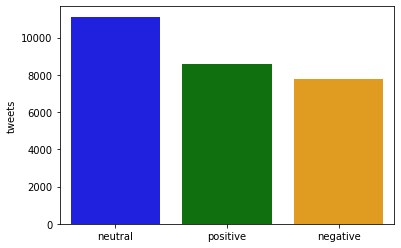

In [14]:
x = train.sentiment.value_counts()
sns.barplot(x.index, x, palette=['blue', 'green', 'orange'])
plt.gca().set_ylabel('tweets')

In [15]:
neutral = train[train['sentiment']=='neutral']
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']

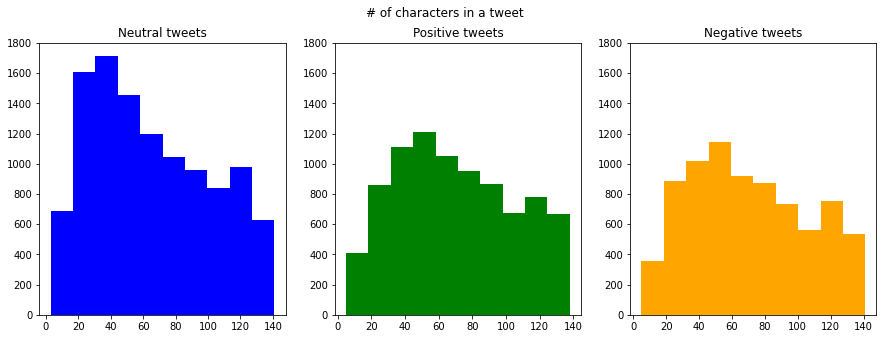

In [16]:
# number of characters, i.e. tweet length

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

tweet_len = neutral['text'].str.len()
ax1.hist(tweet_len, color='blue')
ax1.set_title('Neutral tweets')
ax1.set_ylim([0, 1800])

tweet_len = pos['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Positive tweets')
ax2.set_ylim([0, 1800])

tweet_len = neg['text'].str.len()
ax3.hist(tweet_len, color='orange')
ax3.set_title('Negative tweets')
ax3.set_ylim([0, 1800])


fig.suptitle('# of characters in a tweet')
plt.show()


In [17]:
#fig, ax = plt.subplots()

#tweet_len = pos['text'].str.len()
#sns.distplot(tweet_len, color='red', ax = ax, hist = False)

#tweet_len = neutral['text'].str.len()
#sns.distplot(tweet_len, color='blue', ax = ax, hist = False)


#tweet_len = neg['text'].str.len()
#sns.distplot(tweet_len, color='green', ax = ax, hist = False)

#plt.show()

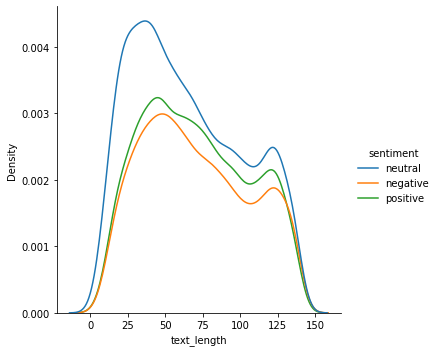

In [18]:
 # initialize data of lists.
data = {'sentiment': train['sentiment'],
        'text_length': train['text'].str.len()}
  
# Create DataFrame
data = pd.DataFrame(data)

sns.displot(data=data, x='text_length', hue = 'sentiment', kind = 'kde')

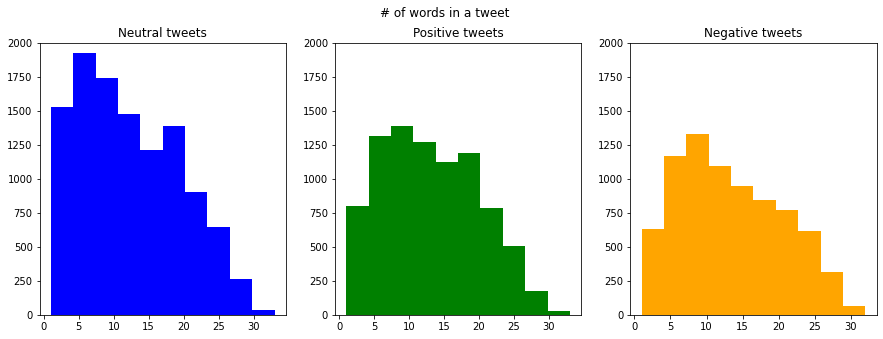

In [19]:
# number of words in a tweet

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

tweet_words = neutral['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_words, color = 'blue')
ax1.set_title('Neutral tweets')
ax1.set_ylim([0,2000])

tweet_words = pos['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_words, color = 'green')
ax2.set_title('Positive tweets')
ax2.set_ylim([0,2000])

tweet_words = neg['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_words, color = 'orange')
ax3.set_title('Negative tweets')
ax3.set_ylim([0,2000])

fig.suptitle('# of words in a tweet')
plt.show()

In [20]:
# fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))

# word = neutral['text'].str.split().apply(lambda x : [len(i) for i in x])
# sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color='blue')
# ax1.set_title('Neutral')
# ax1.set_xlim([0,70])
# ax1.set_ylim([0,0.6])

# word = pos['text'].str.split().apply(lambda x : [len(i) for i in x])
# sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color = 'green')
# ax2.set_title('Positive')
# ax2.set_xlim([0,70])
# ax2.set_ylim([0,0.6])

# word = neg['text'].str.split().apply(lambda x : [len(i) for i in x])
# sns.distplot(word.map(lambda x: np.mean(x)), ax = ax3, color = 'orange')
# ax3.set_title('Negative')
# ax3.set_xlim([0,70])
# ax3.set_ylim([0,0.6])


# fig.suptitle('Average word length in each tweet')

**Clean text**

In [21]:
# Convert text to lowercase
train['text'] = train['text'].str.lower()

# Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
train['text'].replace( {r"`": "'"}, inplace= True, regex = True)
train['text'] = train['text'].apply(contractions.fix)

# Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
train['text'].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

# Remove extra whitespaces
train['text'].replace( {r" +": " "}, inplace= True, regex = True)
train['text'] = train['text'].str.strip()

# Correct spellings
#spell = SpellChecker()

#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = {}
#    words = text.split()
#    for w in spell.unknown(words):
#        corr = spell.correction(w)
#        if corr:
#            misspelled_words[w] = spell.correction(w) or w
#    corrected_text = [misspelled_words.get(w, w) for w in words]
#    return " ".join(corrected_text)

#train['text'] = train['text'].apply(lambda x : correct_spellings(x))

# Remove stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

# Stemming
stemmer = PorterStemmer()
train['text'] = train['text'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

# Lemmatizing
lemmatizer = WordNetLemmatizer()
train['text'] = train['text'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))


In [22]:
print(train.head(20))
print(train['text'].tail(20))

        textID                                               text  \
0   cb774db0d1                                   would respond go   
1   549e992a42                            sooo sad miss san diego   
2   088c60f138                                          bos bulli   
3   9642c003ef                                interview leav alon   
4   358bd9e861                son could put releas alreadi bought   
5   28b57f3990             shameless plug best ranger forum earth   
6   6e0c6d75b1                            feed babi fun smile coo   
7   50e14c0bb8                                         soooo high   
8   e050245fbd                                                      
9   fc2cbefa9d              journey wow becam cooler hehe possibl   
10  2339a9b08b  much love hope reckon chanc minim never go get...   
11  16fab9f95b    realli realli like song love stori taylor swift   
12  74a76f6e0a                          sharpi run danger low ink   
13  04dd1d2e34                    

In [23]:
#spell = SpellChecker()
#lst = [["helloooo frend", 1],["world toor", 0]]
#x = pd.DataFrame(lst, columns =['text', 'sent'])
#print(x)

#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = {}
#    words = text.split()
#    for w in spell.unknown(words):
#        corr = spell.correction(w)
#        if corr:
#            misspelled_words[w] = corr
#    corrected_text = [misspelled_words.get(w, w) for w in words]
#    return " ".join(corrected_text)

#x['text'] = x['text'].apply(lambda t : correct_spellings(t))
#print(x)

In [24]:
tempList = train['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in tempList for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common words','Count']
temp.style.background_gradient(cmap='Blues')

,Common words,Count
1,get,1915
2,good,1601
3,go,1572
4,love,1530
5,work,1530
6,like,1462
7,got,1260
8,want,1241
9,today,1155
10,time,1104


In [25]:
fig = px.bar(temp, x="Count", y="Common words", title='Commmon words in text', orientation='h', width=700, height=700, color='Common words')
fig.show() 

In [26]:
#Most common positive words

pos = train[train['sentiment']=='positive']

tempList = pos['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in tempList for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common words','Count']
temp.style.background_gradient(cmap='Blues')

,Common words,Count
1,love,1196
2,good,1079
3,happi,870
4,thank,864
5,mother,677
6,hope,536
7,like,487
8,great,486
9,get,478
10,go,400


In [27]:
fig = px.bar(temp, x="Count", y="Common words", title='Most commmon positive words', orientation='h', width=700, height=700,color='Common words')
fig.show()

In [28]:
#Most common negative words

neg = train[train['sentiment']=='negative']

tempList = neg['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in tempList for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common words','Count']
temp.style.background_gradient(cmap='Blues')

,Common words,Count
1,get,613
2,go,514
3,work,512
4,like,493
5,cannot,490
6,feel,468
7,day,424
8,want,422
9,sad,406
10,got,360


In [29]:
fig = px.bar(temp, x="Count", y="Common words", title='Most commmon negative words', orientation='h', width=700, height=700,color='Common words')
fig.show()

In [30]:
#Most common neutral words

neutral = train[train['sentiment']=='neutral']

tempList = neutral['text'].apply(lambda x:str(x).split())

top = Counter([item for sublist in tempList for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common words','Count']
temp.style.background_gradient(cmap='Blues')

,Common words,Count
1,work,666
2,day,665
3,go,658
4,want,553
5,got,548
6,lol,500
7,like,482
8,time,476
9,know,462
10,today,452


In [31]:
fig = px.bar(temp, x="Count", y="Common words", title='Most commmon neutral words', orientation='h', width=700, height=700,color='Common words')
fig.show()

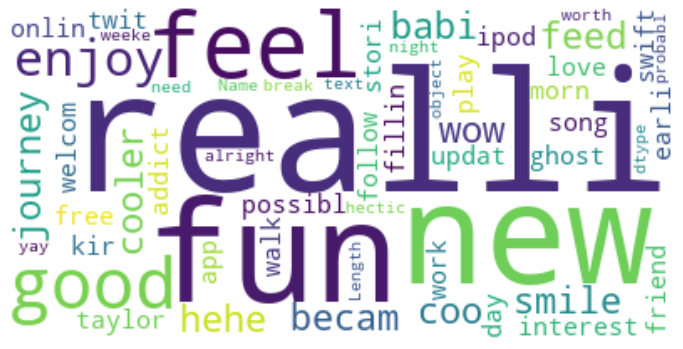

In [32]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(str(pos['text']))

# Display the generated image
plt.figure(figsize=(12.0,8.0))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**SVM using TF-IDF**

In [33]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(train['text'])
test_vectors = vectorizer.transform(test['text'])

In [34]:
# Creating the SVM model using one-vs-rest strategy
model = OneVsRestClassifier(SVC())
   
# Fitting the model with training data
t0 = time.time()
model.fit(train_vectors, train['sentiment'])
t1 = time.time()  

# Making predictions on the test set
prediction = model.predict(test_vectors)
t2 = time.time()

# Evaluating the model
print("Training time: %fs; Prediction time: %fs \n" % (t1-t0, t2-t1))
print(f"Test Set Accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")
print('Test confusion matrix:')
print(confusion_matrix(test['sentiment'], prediction))
print(f"\nClassification Report: \n{classification_report(test['sentiment'], prediction)}")

Training time: 363.797168s; Prediction time: 14.555482s 

Test Set Accuracy: 60.35653650254669 %

Test confusion matrix:
[[ 432  506   63]
 [ 155 1141  134]
 [  36  507  560]]

Classification Report: 
              precision    recall  f1-score   support

    negative       0.69      0.43      0.53      1001
     neutral       0.53      0.80      0.64      1430
    positive       0.74      0.51      0.60      1103

    accuracy                           0.60      3534
   macro avg       0.65      0.58      0.59      3534
weighted avg       0.64      0.60      0.60      3534



In [35]:
# Creating the SVM model using one-vs-one strategy
model = OneVsOneClassifier(SVC())
   
# Fitting the model with training data
t0 = time.time()
model.fit(train_vectors, train['sentiment'])
t1 = time.time()  

# Making a prediction on the test set
prediction = model.predict(test_vectors)
t2 = time.time()

# Evaluating the model
print("Training time: %fs; Prediction time: %fs \n" % (t1-t0, t2-t1))
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")
print('Test confusion matrix:')
print(confusion_matrix(test['sentiment'], prediction))
print(f"\nClassification report: \n{classification_report(test['sentiment'], prediction)}")

Training time: 174.087401s; Prediction time: 22.707620s 

Test set accuracy: 60.63950198075835 %

Test confusion matrix:
[[ 412  542   47]
 [ 130 1178  122]
 [  28  522  553]]

Classification report: 
              precision    recall  f1-score   support

    negative       0.72      0.41      0.52      1001
     neutral       0.53      0.82      0.64      1430
    positive       0.77      0.50      0.61      1103

    accuracy                           0.61      3534
   macro avg       0.67      0.58      0.59      3534
weighted avg       0.66      0.61      0.60      3534

